# Image classification with CNN

In this script we create, train and evaluate an image classifier based on convolutional networks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset

# Define the device and data repository
device = 'cpu'
data_dir = 'data/'

/home/paul/.local/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


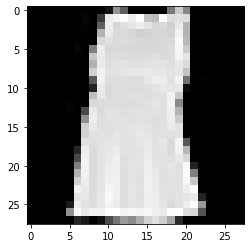

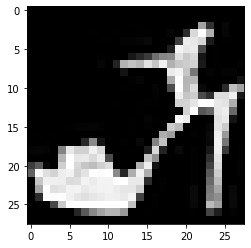

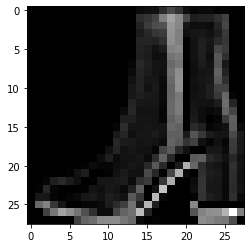

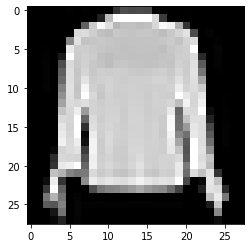

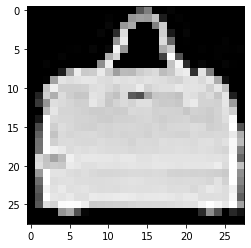

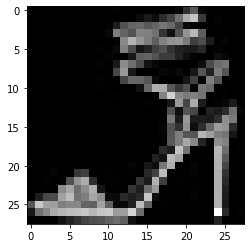

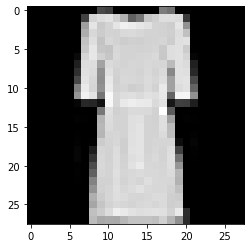

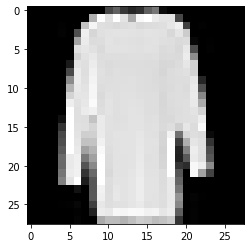

In [2]:
# Let's work with the Fashion MNIST dataset: it's similar to MNIST, but these are images
# of clothes from Zalando instead of digits.

# Create a Dataset (you can download the data by setting'download=True')
train_data = datasets.FashionMNIST(data_dir, train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(data_dir, train=False, download=True, transform=transforms.ToTensor())
num_classes = len(train_data.classes)

# We are not going to work with the full dataset (which is very big), so we only keep small train and test subsets.
train_data = Subset(train_data, torch.arange(500))
test_data = Subset(test_data, torch.arange(50))

# Create dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Get a batch of images from the train dataloader and print it
dataiter = iter(train_dataloader)
image_batch_example = dataiter.next()[0]
for ip in range(batch_size):
    plt.figure()
    plt.imshow(image_batch_example[ip, :].squeeze().detach().numpy(), cmap='gray')
    plt.show()

### Overall architecture

A CNN classifier usually consists of:
- one or several convolutional layers/modules, which produce intermediate latent representations called ***feature maps***
- one or several linear layers, which perform classification from the feature maps

<img src="https://miro.medium.com/max/700/1*LTRcAyl6zuuJvpU-5KECZA.png" />
<center><a href="https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac">Source</a></center>


In [3]:
# Let us create a first CNN layer, with:
# - a convolution function, with 16 output channels, kernel_size=5, padding=2, and bias
# - a non-linear activation function (ReLU)
# - a max pooling function

cnn_layer1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=2))
out1 = cnn_layer1(image_batch_example)
print(out1.shape)

torch.Size([8, 16, 14, 14])


In [4]:
# TO DO: create the second CNN layer, with the same structure as the first one
# (same non-linear activation and max pooling functions), but the convolution function
# now has 16 input channels and 32 output channels (and same kernel_size/padding/stride)
# After creating it, apply it to 'out1' to compute out2, and print the shape of out2.

cnn_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size =2))
out2 = cnn_layer2(out1)
print(out2.shape)

torch.Size([8, 32, 7, 7])


In [5]:
# Now, we need to define a linear layer to perform classification.

# First, we need to reshape out2 to vectorize it.
# The resulting vector should have a shape = (batch_size, 32 x 7 x 7)
out_vec = out2.reshape(out2.shape[0], -1)
print(out_vec.shape)

# TO DO: define a Linear layer with appropriate shape (size of the vectorized input, 10 output classes)
# Apply this layer to the vectorized image
vect_image_size = out_vec.shape[1]
num_classes = 10
lin_layer = nn.Linear(vect_image_size, num_classes)
est_labels = lin_layer(out_vec)
print(est_labels.shape)

torch.Size([8, 1568])
torch.Size([8, 10])


### CNN classifier

Now, let's create a general CNN classification network, train and test it.

In [6]:
# Define a CNN classifier module.

class CNNClassif(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=10):
        super(CNNClassif, self).__init__()
        
        # TO DO: define the convolutional layers 1 and 2 and the linear layer as above.
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(1, num_channels1, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
            
        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.lin_layer = nn.Linear(7*7*num_channels2, num_classes)
        
    def forward(self, x):
        
        # TO DO: write the forward pass, which:
        # - applies the two cnn layers to produce feature maps
        # - vectorize the feature maps
        # - applies the linear layer
        out = self.cnn_layer1(x)
        out = self.cnn_layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.lin_layer(out)
        
        return out 

In [7]:
# Instantiate the model
num_channels1 = 16
num_channels2 = 32
num_classes = 10
model = CNNClassif(num_channels1, num_channels2, num_classes)

# Print the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model.parameters()))

Total number of parameters:  28938


In [8]:
# TO DO: write the training function. It's almost the same as in lab2.2,
# except we don't need to vectorize the images:
# MLP take as input a vector, while CNN directly process the image.

def training_cnn_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True):

    # Set the model
    model = model.to(device)
    model.train()
    
    # define the optimizer (SGD)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Initialize a list to save the training loss over epochs
    loss_total = []
    
    # Training loop
    for epoch in range(num_epochs):
        loss_current_epoch = 0
        for batch_index, (images, labels) in enumerate(train_dataloader):
            # copy images and labels to the device
            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            y_predicted = model(images)
            loss = loss_fn(y_predicted, labels)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Record the loss
            loss_current_epoch += loss.item()

        # At the end of each epoch, save the average loss over batches and display it
        loss_total.append(loss_current_epoch)
        if verbose:
            print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
        
    return model, loss_total

Epoch [1/20], Loss: 144.7847
Epoch [2/20], Loss: 144.4081
Epoch [3/20], Loss: 144.0166
Epoch [4/20], Loss: 143.5967
Epoch [5/20], Loss: 143.1560
Epoch [6/20], Loss: 142.6507
Epoch [7/20], Loss: 142.0900
Epoch [8/20], Loss: 141.4578
Epoch [9/20], Loss: 140.6977
Epoch [10/20], Loss: 139.8041
Epoch [11/20], Loss: 138.6850
Epoch [12/20], Loss: 137.4056
Epoch [13/20], Loss: 135.7830
Epoch [14/20], Loss: 133.8288
Epoch [15/20], Loss: 131.3890
Epoch [16/20], Loss: 128.2400
Epoch [17/20], Loss: 124.4182
Epoch [18/20], Loss: 119.5813
Epoch [19/20], Loss: 113.8049
Epoch [20/20], Loss: 106.9695


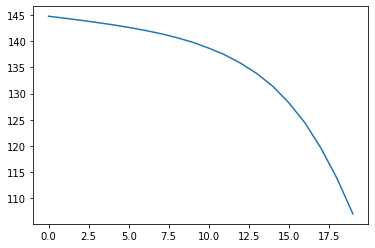

In [9]:
# Optimizer
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001

# Training
model, loss_total = training_cnn_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True)

# Save the model and display the loss over epochs
torch.save(model.state_dict(), 'model_cnn_classif.pt')
plt.plot(loss_total)
plt.show()

In [10]:
# Eval function

def eval_cnn_classifier(model, eval_dataloader, device):

    # Prepare the model (copy to device and disable some layers (batch norm, dropout...) when evaluating
    model.to(device)
    model.eval() 

    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct = 0
        total = 0
        for images, labels in eval_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            y_predicted = model(images)
            _, label_predicted = torch.max(y_predicted.data, 1)
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    
    return accuracy

In [11]:
# TO DO: Evaluate the model on the test set (instantiate the model, load the trained parameters and use the
# evaluation function). Display the accuracy on the test set.

model = CNNClassif(num_channels1, num_channels2, num_classes)
model.load_state_dict(torch.load('model_cnn_classif.pt'))
accuracy = eval_cnn_classifier(model, test_dataloader, device)
print('Accuracy of the network on the test images: ', accuracy, '%')

Accuracy of the network on the test images:  62.0 %


### Batch normalization

When passing images to a CNN, each image might have different distribution / statistics. This causes the gradient at each batch to change a lot, and this makes the stochastic gradient descent algorithm quite unstable.

To prevent from this problem, we use ***batch normalization***, which basically normalizes each batch of data to a given mean / standard deviation. This makes training more stable, and usually significantly faster.

Note: batch normalization should be only used for training, but should be disabled when testing the model. That's why we set `model.eval()` in the evaluation function.

In [12]:
# TO DO : rewrite the CNNClassif module, but insert BatchNorm2D in each module (layer 1 and 2), between RELU and Maxpooling
# See the doc at: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm#torch.nn.BatchNorm2d

class CNNClassif_bnorm(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=10):
        super(CNNClassif_bnorm, self).__init__()
        
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(1, num_channels1, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_channels1),
            nn.MaxPool2d(kernel_size=2))
            
        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_channels2),
            nn.MaxPool2d(kernel_size=2))
        
        self.lin_layer = nn.Linear(7*7*num_channels2, num_classes)
        
    def forward(self, x):
        
        out = self.cnn_layer1(x)
        out = self.cnn_layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.lin_layer(out)
        
        return out 
    

Epoch [1/20], Loss: 96.9381
Epoch [2/20], Loss: 54.5570
Epoch [3/20], Loss: 42.1754
Epoch [4/20], Loss: 34.4241
Epoch [5/20], Loss: 29.2250
Epoch [6/20], Loss: 25.9981
Epoch [7/20], Loss: 22.5605
Epoch [8/20], Loss: 20.5754
Epoch [9/20], Loss: 18.3227
Epoch [10/20], Loss: 16.3528
Epoch [11/20], Loss: 14.4256
Epoch [12/20], Loss: 12.9490
Epoch [13/20], Loss: 11.5689
Epoch [14/20], Loss: 10.6018
Epoch [15/20], Loss: 9.4312
Epoch [16/20], Loss: 8.5604
Epoch [17/20], Loss: 7.8221
Epoch [18/20], Loss: 7.2271
Epoch [19/20], Loss: 6.7256
Epoch [20/20], Loss: 6.2448


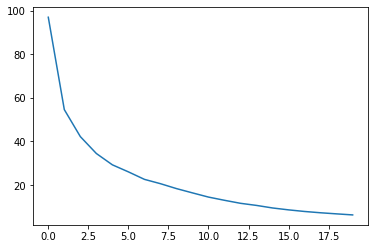

Accuracy of the network on the test images:  76.0 %


In [13]:
# TO DO:
# - instantiate the model
# - train it, save the parameters, and plot the training loss
# - evaluate it and print the test accuracy
# What do you observe?

model_bn = CNNClassif_bnorm(num_channels1, num_channels2, num_classes)

model, loss_total = training_cnn_classifier(model_bn, train_dataloader, num_epochs, loss_fn, learning_rate, device, verbose=True)
torch.save(model_bn.state_dict(), 'model_cnn_classif_bn.pt')
plt.plot(loss_total)
plt.show()

accuracy_bn = eval_cnn_classifier(model_bn, test_dataloader, device)
print('Accuracy of the network on the test images: ', accuracy_bn, '%')

### What's happening inside the network?

Finally, we briefly visualize the feature maps to have a rough understanding of what has been computed through the CNN layers.

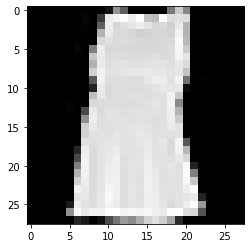

In [14]:
# First, let us retrieve our example and plot it
image_example = image_batch_example[0]
image_example_np = image_example[0].detach().numpy()
plt.figure()
plt.imshow(image_example_np, cmap='gray')
plt.show()

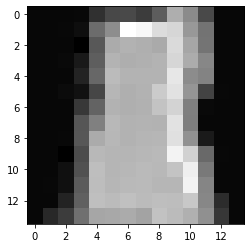

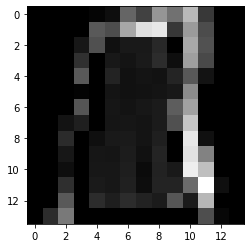

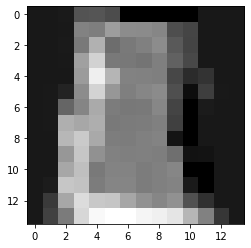

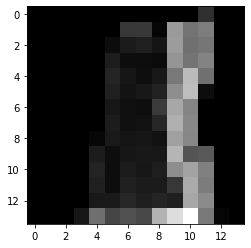

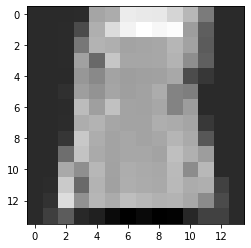

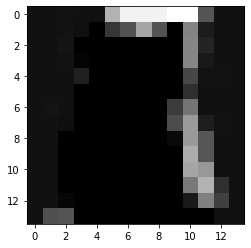

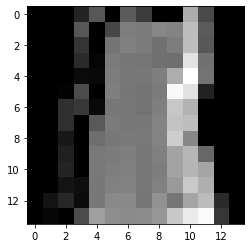

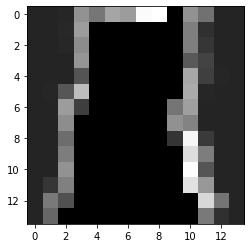

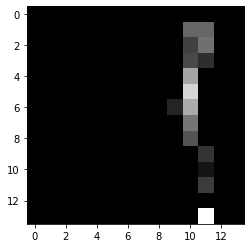

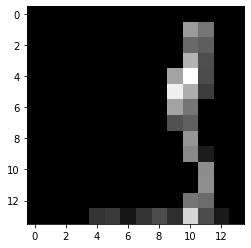

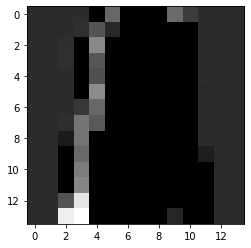

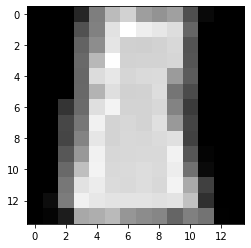

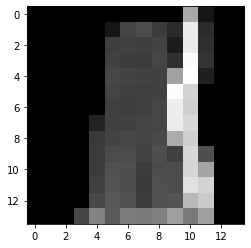

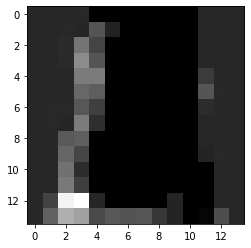

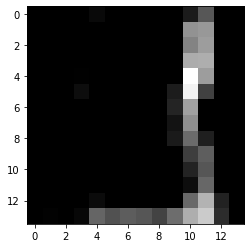

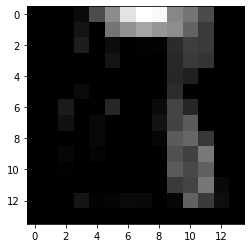

In [15]:
# Instantiate a model and load it's parameters (and disable batch norm)
model_bn = CNNClassif_bnorm(num_channels1, num_channels2, num_classes)
model_bn.load_state_dict(torch.load('model_cnn_classif_bn.pt'))
model_bn.eval()

# Compute the output of the first convolution layer
out_conv1 = model_bn.cnn_layer1(image_batch_example)
out_conv1_np = out_conv1[0].detach().numpy()

# Plot all the feature maps
for ip in range(num_channels1):
    plt.figure()
    plt.imshow(out_conv1_np[ip,:], cmap='gray')
    plt.show()

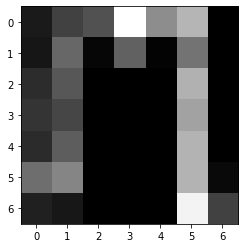

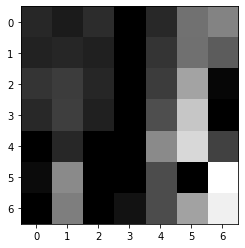

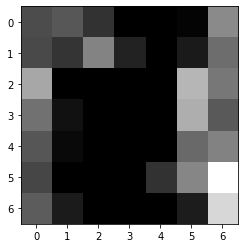

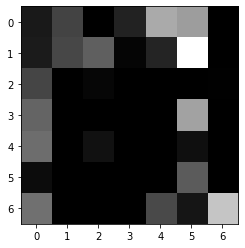

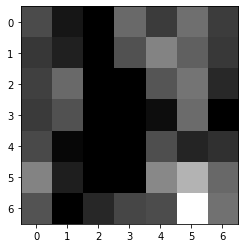

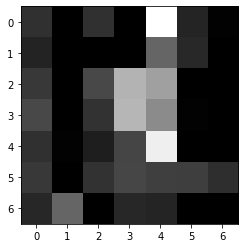

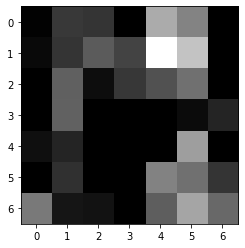

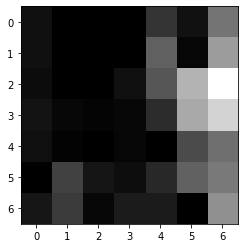

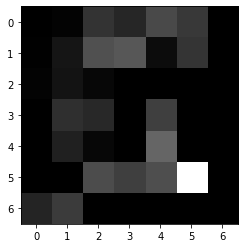

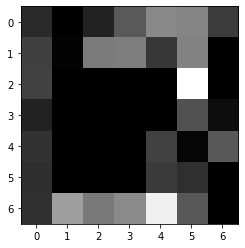

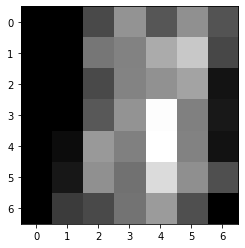

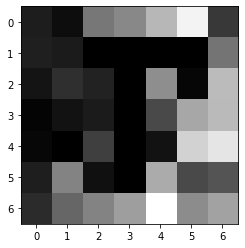

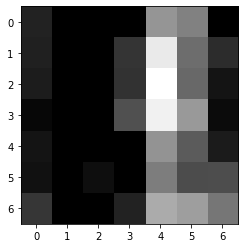

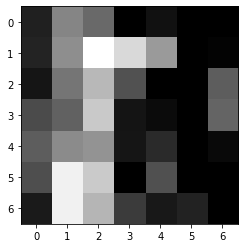

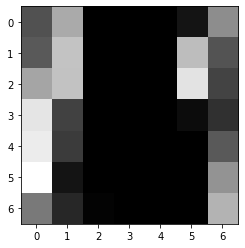

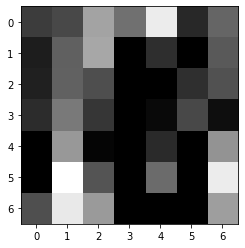

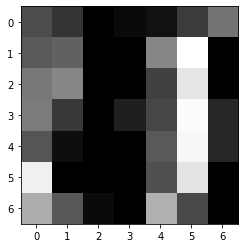

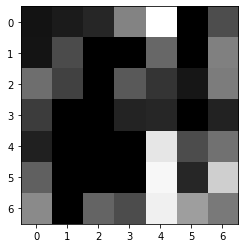

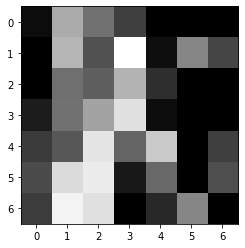

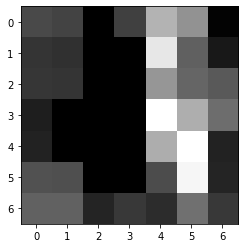

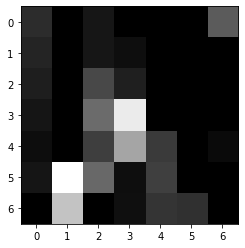

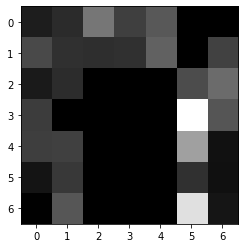

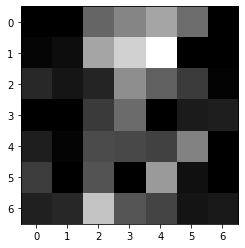

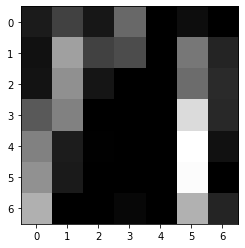

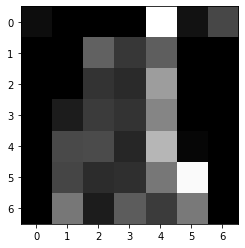

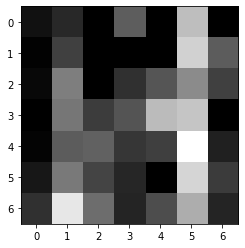

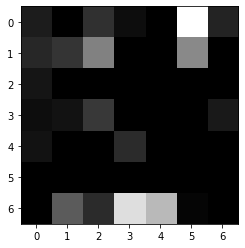

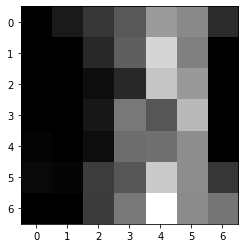

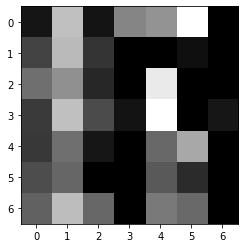

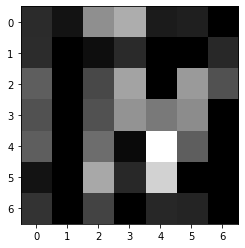

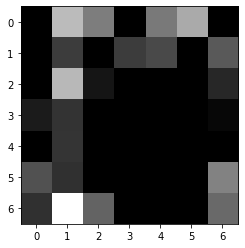

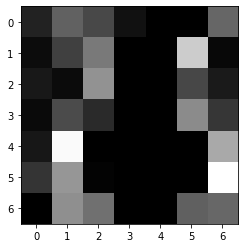

In [16]:
# We now do the same, but with the output of the second convolution layer
out_conv2 = model_bn.cnn_layer2(out_conv1)
out_conv2_np = out_conv2[0].detach().numpy()

# Plot all the feature maps
for ip in range(num_channels2):
    plt.figure()
    plt.imshow(out_conv2_np[ip,:], cmap='gray')
    plt.show()